In [48]:
import os
import glob
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("default") 
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator
import pandas as pd

import geopandas as gpd

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import Point, LineString, Polygon, mapping

import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.features import geometry_mask
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio.plot import plotting_extent
from rasterio.crs import CRS
from rasterio.io import MemoryFile
import tempfile

In [2]:
# Working Directory
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Maps_NA_TX_Data')
# Shapes
tx = gpd.read_file('Texas_State_Boundary')
tx_co = gpd.read_file('Texas_County_Boundaries_Detailed')
tx_watershed = gpd.read_file('tx_watershed')
Counties_1 = gpd.read_file('Counties_1')
Counties_1_Merged = gpd.read_file('Counties_1_Merged')
HUCs = gpd.read_file('Hockly_HUCs')

# Watershed Boundaries
huc8 = "J:///Chomiak_Python/Chomiak_Notebooks/Maps_NA_TX_Data/USGS_HUC_8_Shapefile.zip"    # HUC8
huc8 = gpd.read_file(huc8)    # HUC8
huc8.crs = CRS.from_epsg(4326)       # Change the CRS of the File (Previously 4269)

huc8['BASIN'].unique()

array(['Upper Canadian', 'Middle Candaian', 'Lower Canadian',
       'Upper Beaver', 'Lower Beaver', 'Prairie Dog Town Fork Red',
       'Salt Fork Red', 'North Fork Red', 'Red-Pease', 'Red-Lake Texoma',
       'Washita', 'Red-Little', 'Red-Saline', 'Big Cypress - Sulphur',
       'Sabine', 'Neches', 'Upper Trinity', 'Lower Trinity',
       'San Jacinto', 'Galveston Bay-Sabine Lake', 'Brazos Headwaters',
       'Middle Brazos-Clear Fork', 'Middle Brazos-Bosque', 'Lower Brazos',
       'Little', 'Upper Colorado', 'Middle Colorado-Concho',
       'Middle Colorado-Llano', 'Lower Colorado', 'San Bernard Coastal',
       'Lavaca', 'Guadalupe', 'San Antonio', 'Central Texas Coastal',
       'Nueces', 'Southwestern Texas Coastal', 'Rio Grande-Caballo',
       'Rio Grande-Fort Quitman', 'Rio Grande-Amistad', 'Devils',
       'Rio Grande Closed Basins', 'Upper Pecos', 'Lower Pecos',
       'Rio Grande-Falcon', 'Lower Rio Grande'], dtype=object)

In [3]:
Lower_Colorado = huc8[huc8['BASIN'] == 'Lower Colorado']

In [4]:
#Lower_Colorado.to_file('Lower_Colorado')

<AxesSubplot:>

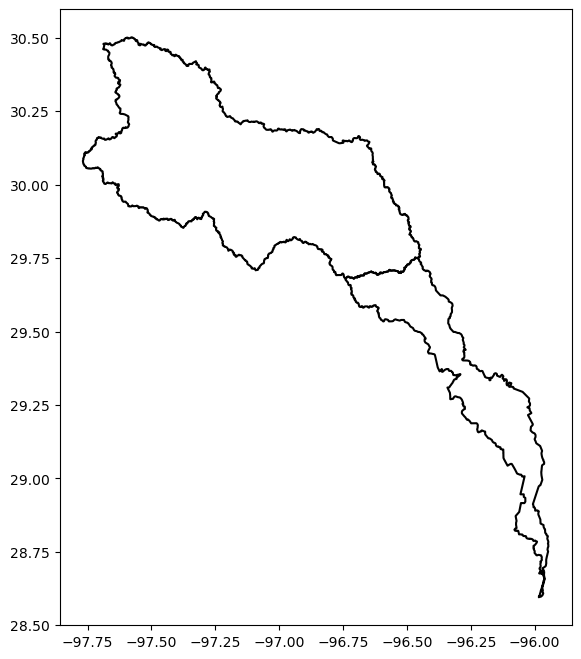

In [5]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))
Lower_Colorado.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=6)

In [6]:

# Reproject the shapefile to match the raster's CRS
raster_crs = 'PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'
lc_reprojected = Lower_Colorado.to_crs(raster_crs)

# Clip Raster to Shapefile

In [7]:
#with rasterio.open('nlcd19_48_lc\\nlcd_2019_land_cover_l48_20210604_TX.img') as src:
#    # Clip the raster
#    clipped_image, clipped_transform = mask(src, lc_reprojected.geometry, crop=True)
#    clipped_meta = src.meta
    
    # Update metadata after clipping
#    clipped_meta.update({
#        "driver": "GTiff",
#        "height": clipped_image.shape[1],
#        "width": clipped_image.shape[2],
#        "transform": clipped_transform
#    })
#    
#    # Save the clipped raster
#    with rasterio.open("NLCD_2019_Lower_Colorado.tif", "w", **clipped_meta) as dest:
#        dest.write(clipped_image)

In [8]:
output_filename = "NLCD_2019_Lower_Colorado.tif"
input_filename = 'nlcd19_48_lc\\nlcd_2019_land_cover_l48_20210604_TX.img'

# Check if the output file already exists
if not os.path.exists(output_filename):
    with rasterio.open(input_filename) as src:
        # Clip the raster
        clipped_image, clipped_transform = mask(src, lc_reprojected.geometry, crop=True)
        clipped_meta = src.meta
        
        # Update metadata after clipping
        clipped_meta.update({
            "driver": "GTiff",
            "height": clipped_image.shape[1],
            "width": clipped_image.shape[2],
            "transform": clipped_transform
        })
        
        # Save the clipped raster
        with rasterio.open(output_filename, "w", **clipped_meta) as dest:
            dest.write(clipped_image)
else:
    print(f"The file {output_filename} already exists. No action was taken.")

The file NLCD_2019_Lower_Colorado.tif already exists. No action was taken.


In [9]:
# Attribute File
df = pd.read_csv('NLCD_2019_Attribute_Tables.csv')
# Extract colors from table
colors = df['Color'].tolist()
# Create the colormap
cmap = plt.matplotlib.colors.ListedColormap(colors)
norm = plt.matplotlib.colors.BoundaryNorm(df['Value'].tolist(), cmap.N)

In [10]:
df

Unnamed: 0  Value    Color                          Name  \
0            0     11  #466b9f                    Open water   
1            1     12  #d1def8            Perennial ice/snow   
2            2     21  #dec5c5         Developed, open space   
3            3     22  #d99282      Developed, low intensity   
4            4     23  #eb0000   Developed, medium intensity   
5            5     24  #ab0000      Developed high intensity   
6            6     31  #b3ac9f  Barren land (rock/sand/clay)   
7            7     41  #68ab5f              Deciduous forest   
8            8     42  #1c5f2c              Evergreen forest   
9            9     43  #b5c58f                  Mixed forest   
10          10     51  #af963c                   Dwarf scrub   
11          11     52  #ccb879                   Shrub/scrub   
12          12     71  #dfdfc2          Grassland/herbaceous   
13          13     72  #d1d182              Sedge/herbaceous   
14          14     73  #a3cc51                       Lichens   
15          15     74  #82ba9e                          Moss   
16          16     81  #dcd939                   Pasture/hay   
17          17     82  #ab6c28              Cultivated crops   
18          18     90  #b8d9eb                Woody wetlands   
19          19     95  #6c9fb8  Emergent herbaceous wetlands   

                                          Description  
0   areas of open water, generally with less than ...  
1   areas characterized by a perennial cover of ic...  
2   areas with a mixture of some constructed mater...  
3   areas with a mixture of constructed materials ...  
4   areas with a mixture of constructed materials ...  
5   highly developed areas where people reside or ...  
6   areas of bedrock, desert pavement, scarps, tal...  
7   areas dominated by trees generally greater tha...  
8   areas dominated by trees generally greater tha...  
9   areas dominated by trees generally greater tha...  
10  Alaska only areas dominated by shrubs less tha...  
11  areas dominated by shrubs less than 5 meters t...  
12  areas dominated by gramanoid or herbaceous veg...  
13  Alaska only areas dominated by sedges and forb...  
14  Alaska only areas dominated by fruticose or fo...  
15  Alaska only areas dominated by mosses, general...  
16  areas of grasses, legumes, or grass-legume mix...  
17  areas used for the production of annual crops,...  
18  areas where forest or shrubland vegetation acc...  
19  areas where perennial herbaceous vegetation ac...

In [11]:
# Open the raster
with rasterio.open("NLCD_2019_Lower_Colorado.tif") as src:
    meta = src.meta

meta

{'driver': 'GTiff',
 'dtype': 'int8',
 'nodata': -128.0,
 'width': 5851,
 'height': 7087,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(30.0, 0.0, -170295.0,
        0.0, -30.0, 826335.0)}

<AxesSubplot:title={'center':'National Land Cover Database 2019'}>

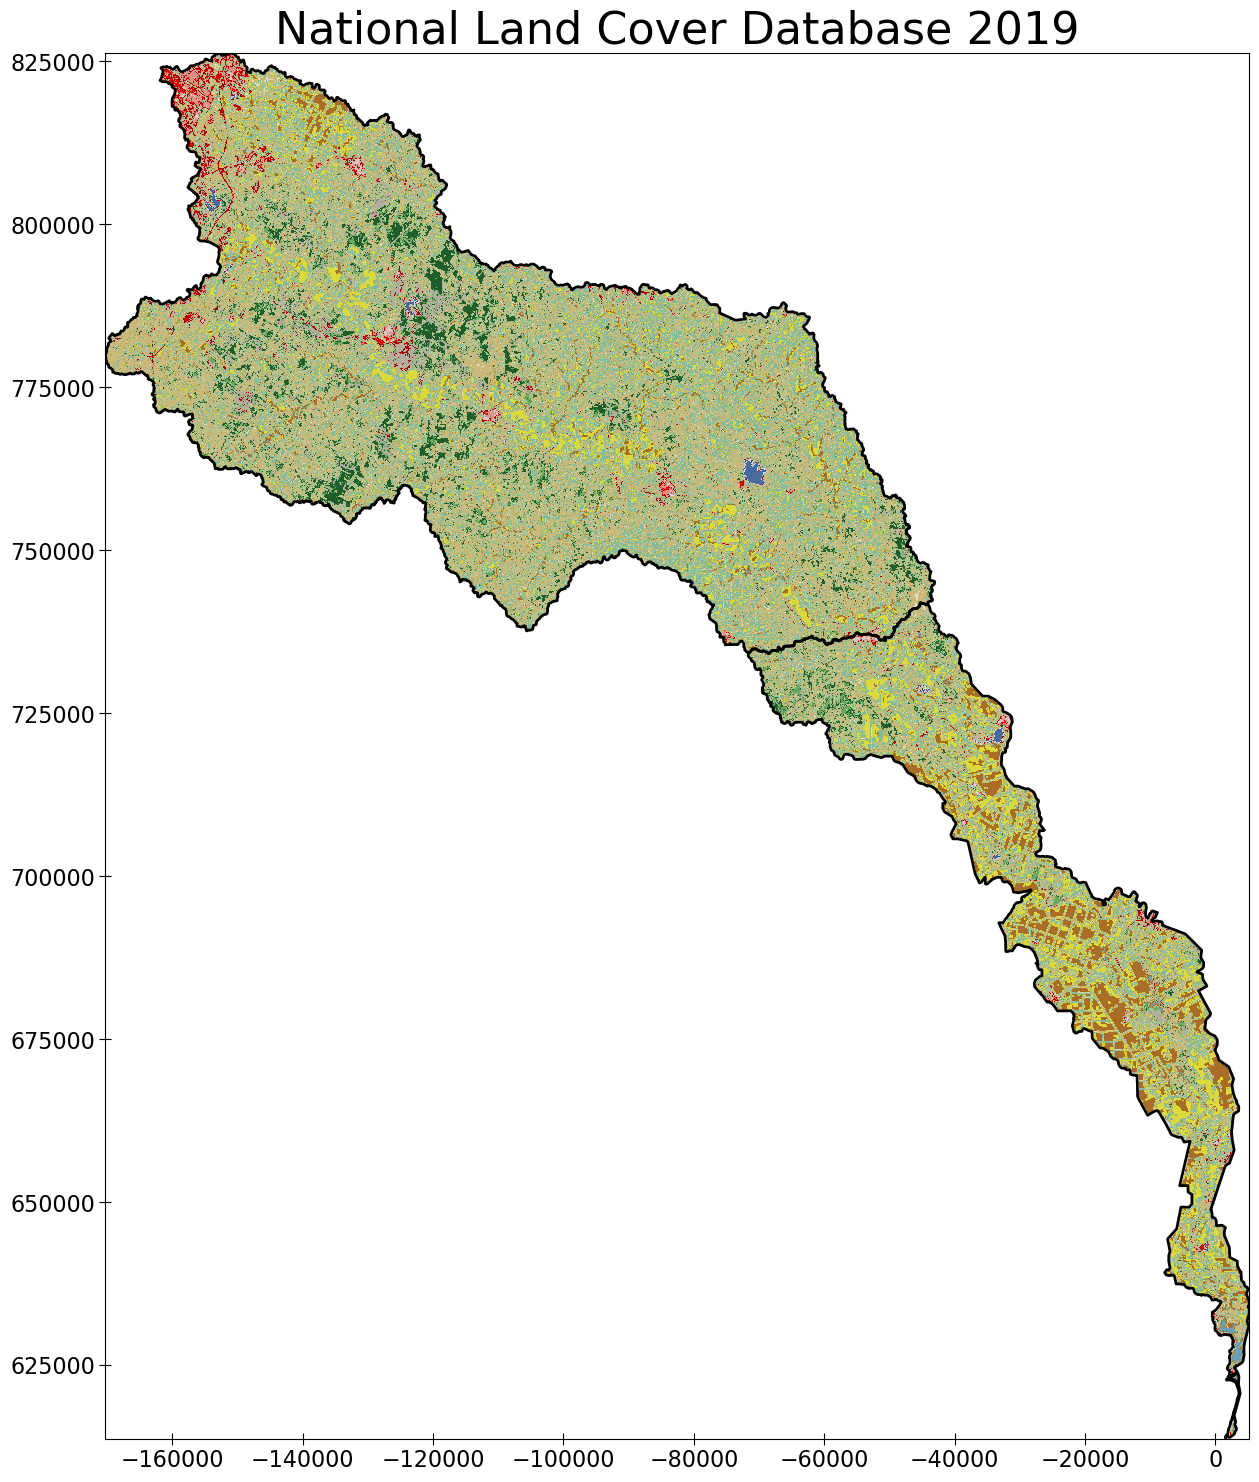

In [12]:
# Open the raster
with rasterio.open("NLCD_2019_Lower_Colorado.tif") as src:
    # Read the data
    data = src.read(1)
    # Get the raster's bounds
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Create a masked array where the nodata values are masked out
    masked_array = np.ma.masked_where(data == src.nodata, data)
    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 18))

# Display the raster using the raster_extent
img = ax.imshow(masked_array, cmap=cmap, norm=norm, extent=raster_extent) # cmap=cmap, norm=norm, 

# Set title and labels
ax.set_title('National Land Cover Database 2019', fontsize=32)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Shapes
#sample_location_reprojected.plot(ax=ax, color='white', edgecolor='black', marker='*', markersize=1200, lw=3, zorder=6)
lc_reprojected.plot(ax=ax, color='none', edgecolor='black', lw=2)

#sample_location_reprojected.plot(ax=ax, color='white', edgecolor='black', marker='*', markersize=1200, lw=3, zorder=6)
#bounding_box.plot(ax=ax, color='none', edgecolor='black', lw=2)


#HydroRIVERS_TX_SJRB_Spring_reprojected.plot(ax=ax, column='ORD_FLOW', color='darkblue', lw=4, zorder=3, label='10$^1$ - 10$^2$ [m$^3$/s]')

#fig.savefig("Chomiak_TX_Images_2023\2019_NLCD_Galveston_Bay.png", dpi=800, bbox_inches='tight')
# Close the figure without displaying it
#plt.close(fig)

In [13]:
# Open the raster
with rasterio.open("NLCD_2019_Lower_Colorado.tif") as src:
    # Read the data
    data = src.read(1)
    # Get metadata and transform
    meta = src.meta
    transform = src.transform

# Calculate pixel area from the transform (product of pixel width and height in the units of the CRS)
pixel_area = transform[0] * -transform[4]

# Exclude nodata value and calculate pixel counts
nodata = meta['nodata']
unique, counts = np.unique(data[data != nodata], return_counts=True)
pixel_counts = dict(zip(unique, counts))

# Create a DataFrame with land cover values and pixel counts
land_cover_areas = pd.DataFrame({
    'Value': unique,
    'PixelCount': counts
})

# Calculate the area for each land cover type
land_cover_areas['Area_m2'] = land_cover_areas['PixelCount'] * pixel_area

# Merge the DataFrame with the attribute table to get land cover names and descriptions
land_cover_areas = land_cover_areas.merge(df[['Value', 'Name', 'Color', 'Description']], on='Value', how='left')

# Calculate the total area covered by all land cover types
total_area = land_cover_areas['Area_m2'].sum()

# Calculate the percentage of the total area for each land cover type
land_cover_areas['PercentArea'] = (land_cover_areas['Area_m2'] / total_area) * 100

# Remove any rows with no corresponding land cover type name (if any)
land_cover_areas = land_cover_areas.dropna(subset=['Name'])

# Sort by area in descending order (optional)
land_cover_areas = land_cover_areas.sort_values(by='Area_m2', ascending=False)

land_cover_areas

Value  PixelCount       Area_m2                          Name    Color  \
12     81     3330236  2.997212e+09                   Pasture/hay  #dcd939   
13     82      990693  8.916237e+08              Cultivated crops  #ab6c28   
7      41      786857  7.081713e+08              Deciduous forest  #68ab5f   
8      42      734301  6.608709e+08              Evergreen forest  #1c5f2c   
10     52      723170  6.508530e+08                   Shrub/scrub  #ccb879   
9      43      504941  4.544469e+08                  Mixed forest  #b5c58f   
2      21      338581  3.047229e+08         Developed, open space  #dec5c5   
14     90      308343  2.775087e+08                Woody wetlands  #b8d9eb   
11     71      173016  1.557144e+08          Grassland/herbaceous  #dfdfc2   
3      22      147943  1.331487e+08      Developed, low intensity  #d99282   
1      11      116955  1.052595e+08                    Open water  #466b9f   
4      23      109743  9.876870e+07   Developed, medium intensity  #eb0000   
5      24       35409  3.186810e+07      Developed high intensity  #ab0000   
15     95       29932  2.693880e+07  Emergent herbaceous wetlands  #6c9fb8   
6      31       20795  1.871550e+07  Barren land (rock/sand/clay)  #b3ac9f   

                                          Description  PercentArea  
12  areas of grasses, legumes, or grass-legume mix...    39.739480  
13  areas used for the production of annual crops,...    11.821872  
7   areas dominated by trees generally greater tha...     9.389511  
8   areas dominated by trees generally greater tha...     8.762364  
10  areas dominated by shrubs less than 5 meters t...     8.629539  
9   areas dominated by trees generally greater tha...     6.025427  
2   areas with a mixture of some constructed mater...     4.040264  
14  areas where forest or shrubland vegetation acc...     3.679436  
11  areas dominated by gramanoid or herbaceous veg...     2.064588  
3   areas with a mixture of constructed materials ...     1.765394  
1   areas of open water, generally with less than ...     1.395616  
4   areas with a mixture of constructed materials ...     1.309556  
5   highly developed areas where people reside or ...     0.422533  
15  areas where perennial herbaceous vegetation ac...     0.357177  
6   areas of bedrock, desert pavement, scarps, tal...     0.248145

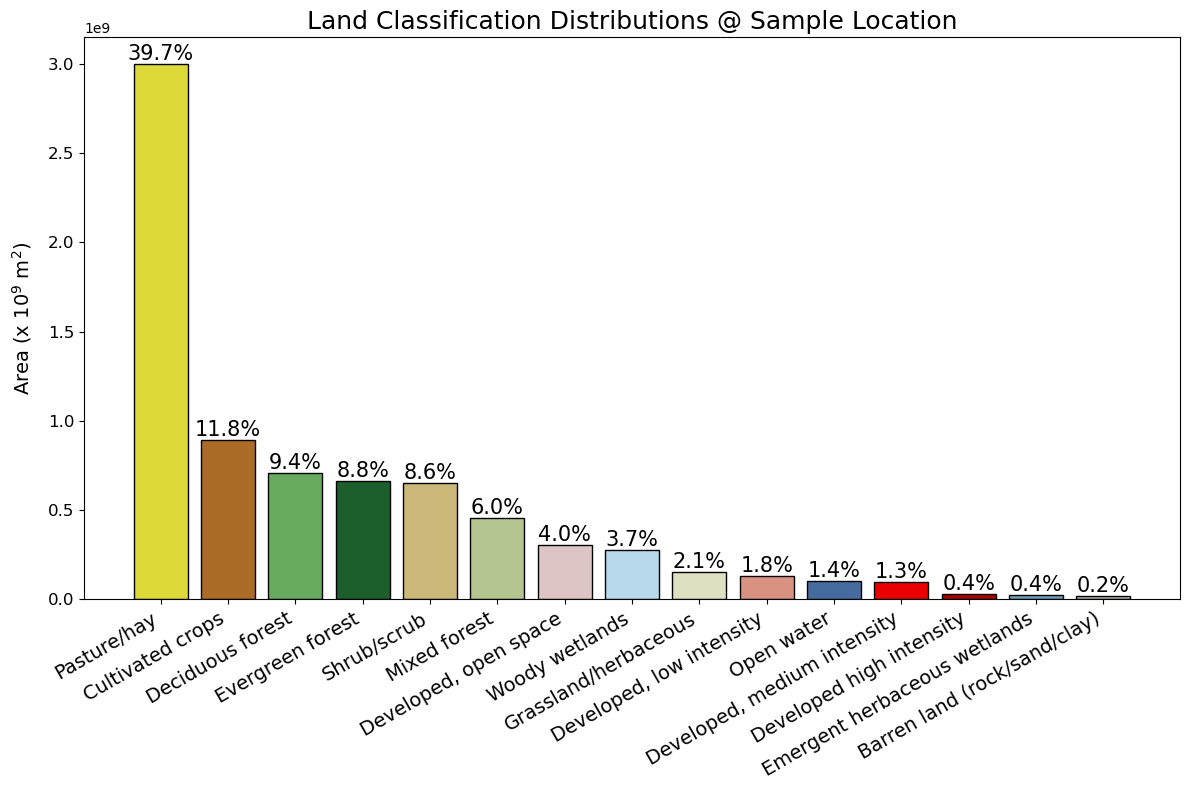

In [14]:
# Create the bar plot using the top 15 records
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(land_cover_areas['Name'], land_cover_areas['Area_m2'], color=land_cover_areas['Color'], edgecolor='black', align='center')

# Set title and labels
ax.set_title('Land Classification Distributions @ Sample Location', fontsize=18)
ax.set_ylabel('Area (x $10^9$ m$^2$)', fontsize=14, labelpad=10)
#ax.set_xlabel('Soil Taxonomic Classes', fontsize=14)

# Add text above each bar
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    # Multiply by 100 to convert proportion to percentage
    percentage = land_cover_areas['PercentArea'].iloc[idx]
    # Format with one decimal place and add a percentage sign
    ax.text(bar.get_x() + bar.get_width()/2, 
            yval + 0.00*yval, 
            '{:.1f}%'.format(percentage), 
            ha='center', va='bottom', fontsize=15)


# Rotate x labels for better readability
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=12)
fig.tight_layout()

- https://data.tnris.org/collection/?c=447db89a-58ee-4a1b-a61f-b918af2fb0bb

In [15]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_raster(input_raster, output_raster, new_crs):
    """Reproject a raster to a new coordinate reference system."""
    with rasterio.open(input_raster) as src:
        transform, width, height = calculate_default_transform(
            src.crs, new_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': new_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_raster, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=new_crs,
                    resampling=Resampling.bilinear
                )
    print(f"Raster reprojected to {new_crs} and saved as {output_raster}.")

In [16]:
# Use the function to reproject the raster
new_crs = 'EPSG:4326'
huc_all = 'NLCD_2019_Lower_Colorado.tif'
reproject_raster(huc_all, "NLCD_2019_Lower_Colorado_4326.tif", new_crs)

Raster reprojected to EPSG:4326 and saved as NLCD_2019_Lower_Colorado_4326.tif.


In [17]:
HydroRIVERS_TX = gpd.read_file("HydroRIVERS_Texas")
# Clip to San Jacinto River Basin
HydroRIVERS_lc = HydroRIVERS_TX[HydroRIVERS_TX.within(Lower_Colorado.unary_union)]
#HydroRIVERS_TX_SJRB.to_file('HydroRIVERS_TX_SJRB\HydroRIVERS_TX_SJRB.shp', crs='EPSG:4326', driver = 'ESRI Shapefile')

In [18]:
# ORD_FLOW
f_1 = HydroRIVERS_lc.loc[HydroRIVERS_lc['ORD_FLOW'] == 1]
f_2 = HydroRIVERS_lc.loc[HydroRIVERS_lc['ORD_FLOW'] == 2]
f_3 = HydroRIVERS_lc.loc[HydroRIVERS_lc['ORD_FLOW'] == 3]
f_4 = HydroRIVERS_lc.loc[HydroRIVERS_lc['ORD_FLOW'] == 4]
f_5 = HydroRIVERS_lc.loc[HydroRIVERS_lc['ORD_FLOW'] == 5]
f_6 = HydroRIVERS_lc.loc[HydroRIVERS_lc['ORD_FLOW'] == 6]
f_7 = HydroRIVERS_lc.loc[HydroRIVERS_lc['ORD_FLOW'] == 7]
f_8 = HydroRIVERS_lc.loc[HydroRIVERS_lc['ORD_FLOW'] == 8]
f_9 = HydroRIVERS_lc.loc[HydroRIVERS_lc['ORD_FLOW'] == 9]
f_10 = HydroRIVERS_lc.loc[HydroRIVERS_lc['ORD_FLOW'] == 10]
f_11 = HydroRIVERS_lc.loc[HydroRIVERS_lc['ORD_FLOW'] == 11]

print('Shapes:')
print('HydroRIVERS_flow_1: ', f_1.shape)
print('HydroRIVERS_flow_2: ', f_2.shape)
print('HydroRIVERS_flow_3: ', f_3.shape)
print('HydroRIVERS_flow_4: ', f_4.shape)
print('HydroRIVERS_flow_5: ', f_5.shape)
print('HydroRIVERS_flow_6: ', f_6.shape)
print('HydroRIVERS_flow_7: ', f_7.shape)
print('HydroRIVERS_flow_8: ', f_8.shape)
print('HydroRIVERS_flow_9: ', f_9.shape)
print('HydroRIVERS_flow_10: ', f_10.shape)
print('HydroRIVERS_flow_11: ', f_11.shape)

Shapes:
HydroRIVERS_flow_1:  (0, 16)
HydroRIVERS_flow_2:  (0, 16)
HydroRIVERS_flow_3:  (0, 16)
HydroRIVERS_flow_4:  (89, 16)
HydroRIVERS_flow_5:  (0, 16)
HydroRIVERS_flow_6:  (62, 16)
HydroRIVERS_flow_7:  (223, 16)
HydroRIVERS_flow_8:  (14, 16)
HydroRIVERS_flow_9:  (0, 16)
HydroRIVERS_flow_10:  (0, 16)
HydroRIVERS_flow_11:  (0, 16)


<AxesSubplot:title={'center':'National Land Cover Database 2019'}>

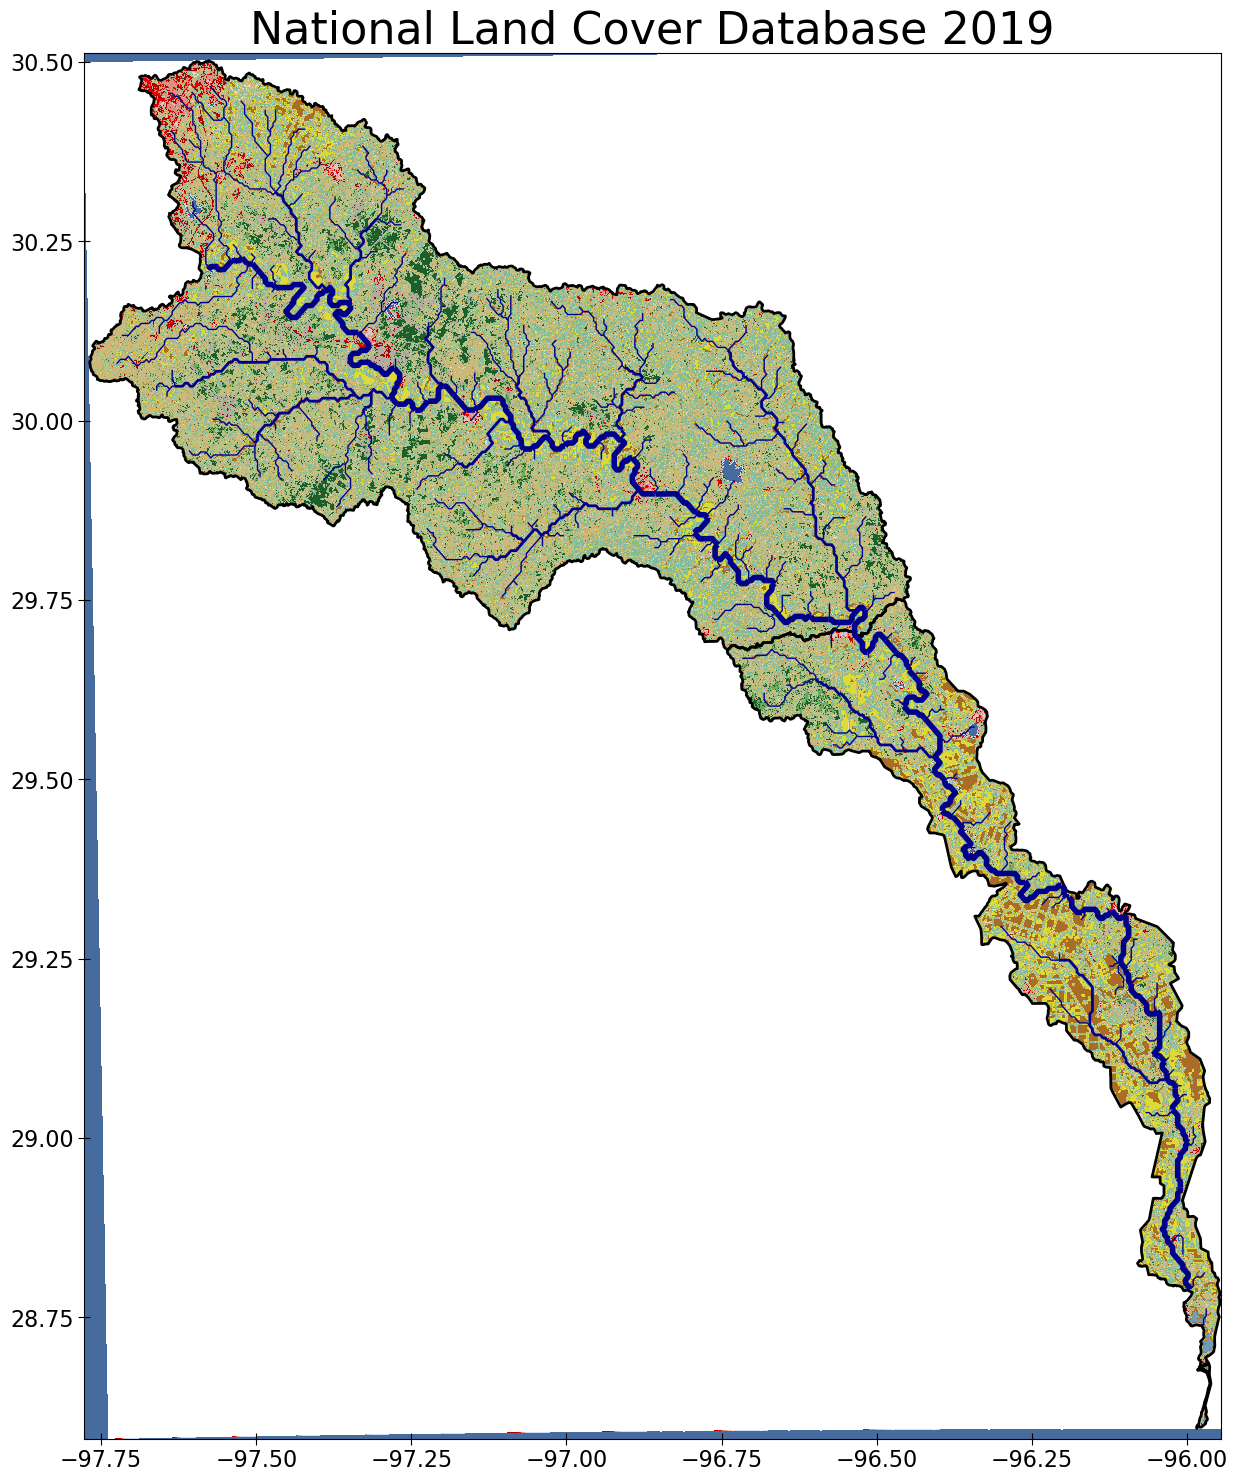

In [19]:
# Open the raster
with rasterio.open("NLCD_2019_Lower_Colorado_4326.tif") as src:
    # Read the data
    data = src.read(1)
    # Get the raster's bounds
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Create a masked array where the nodata values are masked out
    masked_array = np.ma.masked_where(data == src.nodata, data)
    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 18))

# Display the raster using the raster_extent
img = ax.imshow(masked_array, cmap=cmap, norm=norm, extent=raster_extent) # cmap=cmap, norm=norm, 

# Set title and labels
ax.set_title('National Land Cover Database 2019', fontsize=32)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Shapes
#sample_location_reprojected.plot(ax=ax, color='white', edgecolor='black', marker='*', markersize=1200, lw=3, zorder=6)
Lower_Colorado.plot(ax=ax, color='none', edgecolor='black', lw=2)

#sample_location_reprojected.plot(ax=ax, color='white', edgecolor='black', marker='*', markersize=1200, lw=3, zorder=6)
#bounding_box.plot(ax=ax, color='none', edgecolor='black', lw=2)


# Hydrology
#HydroRIVERS_TX_SJRB_Spring.plot(ax=ax, column='ORD_FLOW', color='darkblue', lw=4, zorder=3, label='10$^1$ - 10$^2$ [m$^3$/s]')
f_4.plot(ax=ax, color='darkblue', lw=4, zorder=3)
f_6.plot(ax=ax, color='darkblue', lw=2, zorder=4)
f_7.plot(ax=ax, color='darkblue', lw=1, zorder=5)
f_8.plot(ax=ax, color='darkblue', lw=1, zorder=6)


#fig.savefig("Chomiak_TX_Images_2023\2019_NLCD_Galveston_Bay.png", dpi=800, bbox_inches='tight')
# Close the figure without displaying it
#plt.close(fig)

# Conditioned DEM (HydroSHEDS)

In [31]:
os.getcwd()

'J:\\Chomiak_Python\\Chomiak_Notebooks\\Maps_NA_TX_Data'

In [32]:
dem_file = 'Hydrosheds_na_conditioned_dem_3s\\na_con_3s.tif'

In [33]:
# Open the raster
with rasterio.open(dem_file) as src:
    meta = src.meta

meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': 32767.0,
 'width': 120000,
 'height': 72000,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.000833333333333333, 0.0, -150.0,
        0.0, -0.000833333333333333, 59.99999999999999)}

In [34]:
with rasterio.open(dem_file) as src:
    # Clip the raster
    clipped_image, clipped_transform = mask(src, Lower_Colorado.geometry, crop=True)
    clipped_meta = src.meta
   
   # Update metadata after clipping
    clipped_meta.update({
        "driver": "GTiff",
        "height": clipped_image.shape[1],
        "width": clipped_image.shape[2],
        "transform": clipped_transform
    })
    
    # Save the clipped raster
    with rasterio.open("na_con_3s_Lower_Colorado.tif", "w", **clipped_meta) as dest:
        dest.write(clipped_image)

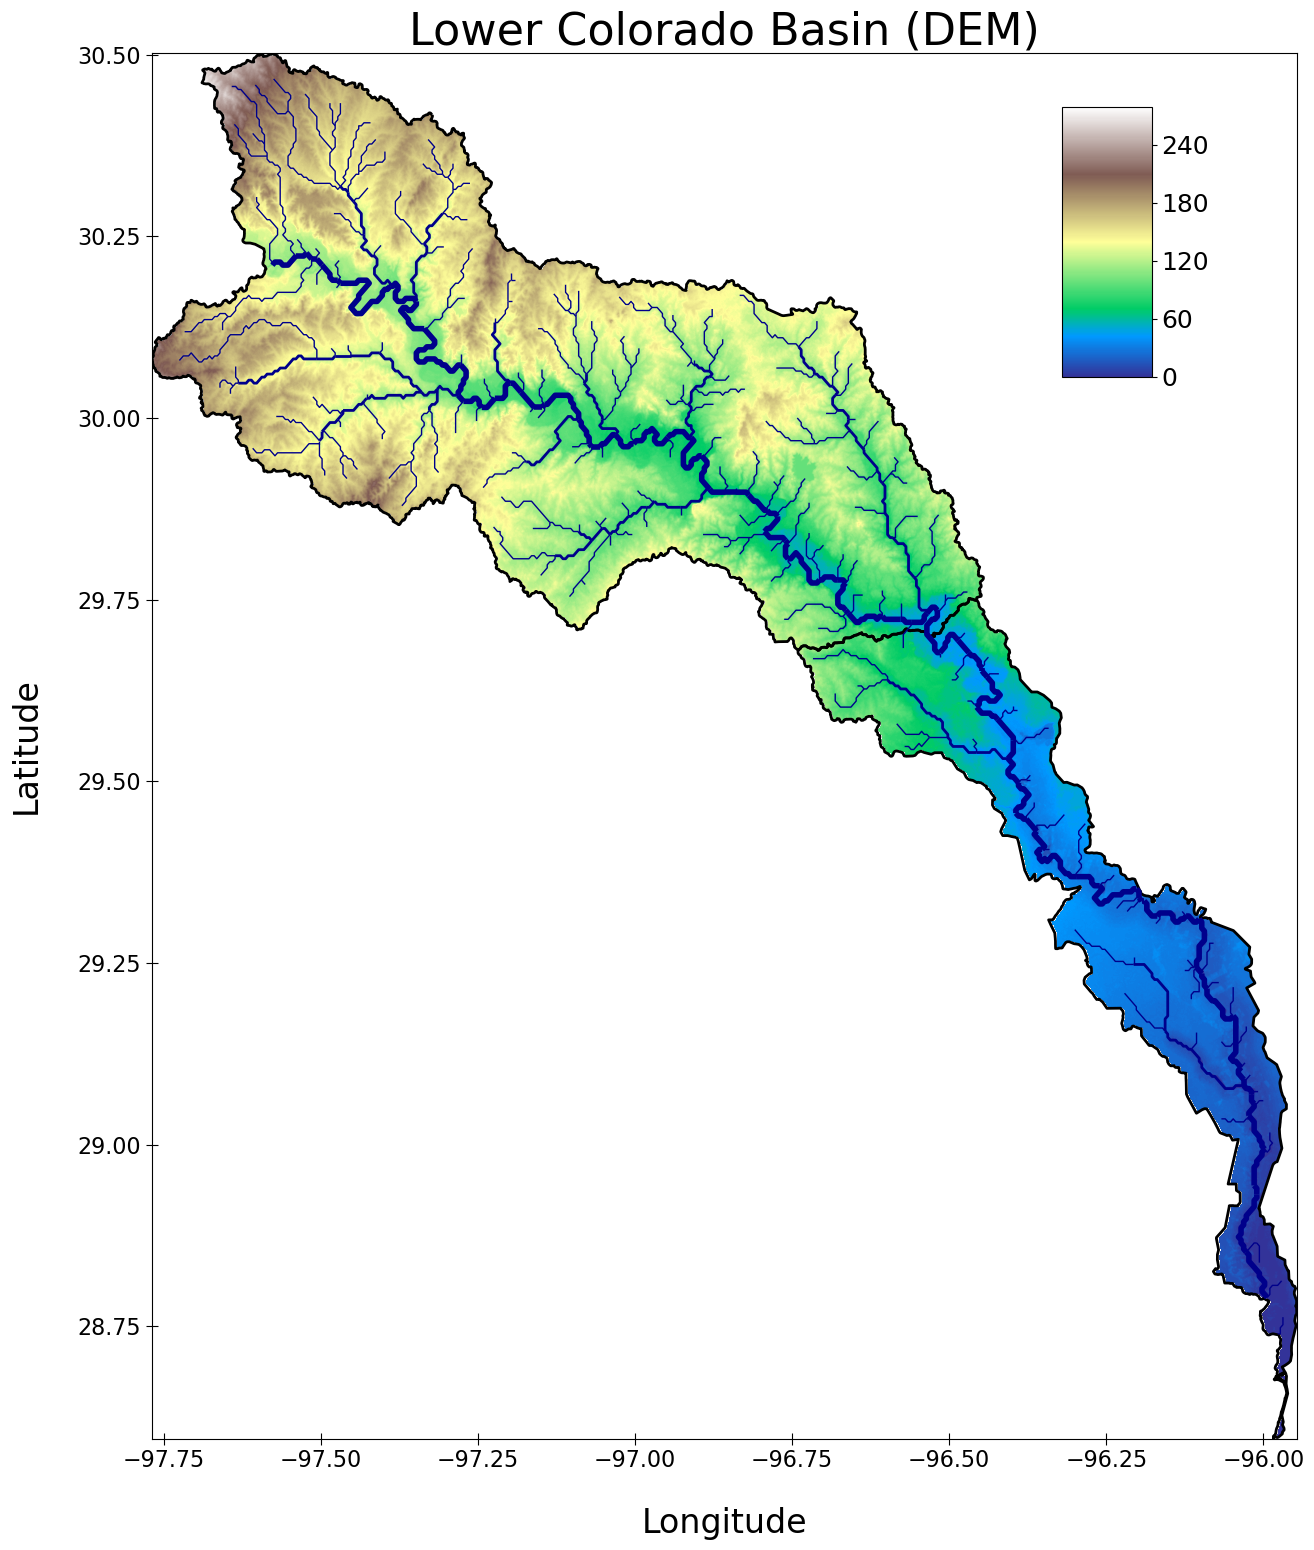

In [50]:
# Open the clipped raster
with rasterio.open("na_con_3s_Lower_Colorado.tif") as dem_raster:
    # Read the raster data
    array = dem_raster.read(1)
    
    # Mask nodata values
    nodata = dem_raster.nodata
    masked_array = np.ma.masked_where(array == nodata, array)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(18, 18))
    
    # Display the raster
    img = ax.imshow(masked_array, cmap='terrain', extent=[dem_raster.bounds[0], dem_raster.bounds[2], dem_raster.bounds[1], dem_raster.bounds[3]])
    # Shapefiles
    Lower_Colorado.plot(ax=ax, color='none', edgecolor='black', lw=2)
    f_4.plot(ax=ax, color='darkblue', lw=4, zorder=3)
    f_6.plot(ax=ax, color='darkblue', lw=2, zorder=4)
    f_7.plot(ax=ax, color='darkblue', lw=1, zorder=5)
    f_8.plot(ax=ax, color='darkblue', lw=1, zorder=6)
    
    # Manually define a position for the colorbar inside the plot
    cax_position = [0.70, 0.70, 0.05, 0.15]  # [left, bottom, width, height]
    cax = fig.add_axes(cax_position)
    colorbar = fig.colorbar(img, cax=cax, orientation='vertical', pad=0.01, aspect=5, shrink=0.333)
    colorbar.ax.tick_params(labelsize=18)
    # Set the locator for the ticks
    colorbar.locator = MaxNLocator(nbins=5)  # 'nbins' determines the maximum number of ticks
    colorbar.update_ticks()
    #cax.set_label(r'[$\frac{tonnes}{hectare}$]', fontsize=18, labelpad=15)
    
    # Set title and labels
    ax.set_title('Lower Colorado Basin (DEM)', fontsize=32)
    ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
    ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
    ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Flow Accumulation

In [52]:
dem_file = 'na_acc_3s\\na_acc_3s.tif'

# Open the raster
with rasterio.open(dem_file) as src:
    meta = src.meta

meta

{'driver': 'GTiff',
 'dtype': 'uint32',
 'nodata': 4294967295.0,
 'width': 120000,
 'height': 72000,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.000833333333333333, 0.0, -150.0,
        0.0, -0.000833333333333333, 59.99999999999999)}

In [53]:
with rasterio.open(dem_file) as src:
    # Clip the raster
    clipped_image, clipped_transform = mask(src, Lower_Colorado.geometry, crop=True)
    clipped_meta = src.meta
   
   # Update metadata after clipping
    clipped_meta.update({
        "driver": "GTiff",
        "height": clipped_image.shape[1],
        "width": clipped_image.shape[2],
        "transform": clipped_transform
    })
    
    # Save the clipped raster
    with rasterio.open("na_acc_3s_Lower_Colorado.tif", "w", **clipped_meta) as dest:
        dest.write(clipped_image)

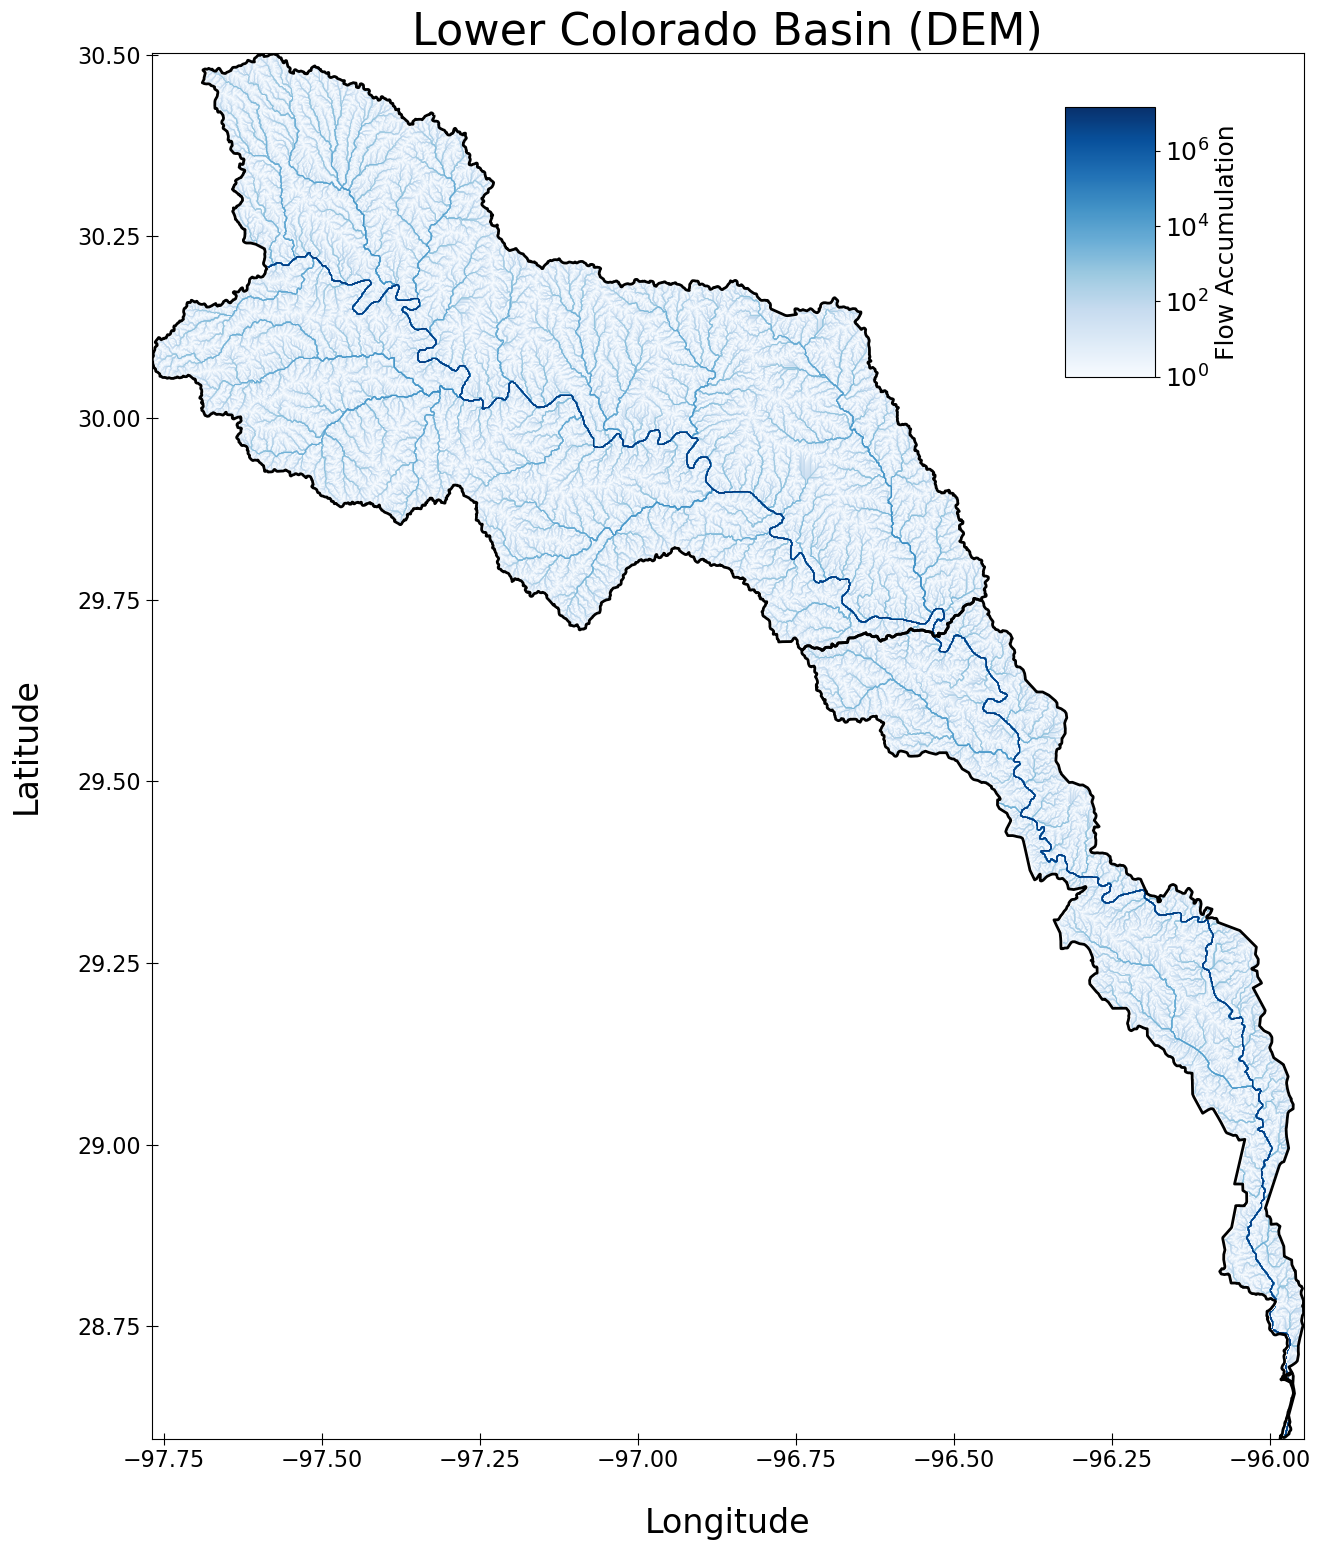

In [65]:
from matplotlib.colors import LogNorm

# Open the clipped raster
with rasterio.open("na_acc_3s_Lower_Colorado.tif") as dem_raster:
    # Read the raster data
    array = dem_raster.read(1)
    
    # Mask nodata values
    nodata = dem_raster.nodata
    masked_array = np.ma.masked_where(array == nodata, array)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(18, 18))
    
    # Display the raster with logarithmic scaling
    img = ax.imshow(masked_array, cmap='Blues', norm=LogNorm(), extent=[dem_raster.bounds[0], dem_raster.bounds[2], dem_raster.bounds[1], dem_raster.bounds[3]])
    
    # Shapefiles
    Lower_Colorado.plot(ax=ax, color='none', edgecolor='black', lw=2)
    
    # Manually define a position for the colorbar inside the plot
    cax_position = [0.70, 0.70, 0.05, 0.15]  # [left, bottom, width, height]
    cax = fig.add_axes(cax_position)
    colorbar = fig.colorbar(img, cax=cax, orientation='vertical', pad=0.01, aspect=5)
    colorbar.ax.tick_params(labelsize=18)
    colorbar.set_label('Flow Accumulation', fontsize=18)
    
    # Set title and labels
    ax.set_title('Lower Colorado Basin (DEM)', fontsize=32)
    ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
    ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
    ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

Flow accumulation in hydrological modeling is a measure of the amount of upstream area that contributes flow to a particular point in the landscape. It's often used in GIS and remote sensing to identify streams and predict potential locations for water accumulation and runoff.

The flow accumulation value for each cell in a raster grid represents the number of cells upstream of that cell that flow into it. This is typically calculated by taking the flow direction raster (which indicates the direction water will flow out of each cell) and accumulating the count of cells along these flow paths.

Units:

ACC (Cell Count): The unit is the number of cells. No specific physical unit is attached; it's just a count of the number of upstream cells.

ACA (Area): The unit is typically in hectares or square meters. This is the actual physical area of the land surface that drains into a particular point.

The flow accumulation map can be interpreted as follows:

Low Values: Indicate that few cells contribute to the flow at that point, often representing upland or headwater regions.
High Values: Represent areas with large upstream catchment areas, such as downstream or near river outlets.
For practical applications like flood modeling, flow accumulation rasters are often used to delineate stream networks by applying a threshold value. Any cell with a flow accumulation above this threshold is considered part of the stream network. This threshold is chosen based on the size of the smallest stream you wish to identify and the resolution of your data.

When using flow accumulation data, especially when dealing with a geographic coordinate system like WGS84, it's important to remember that the area represented by each cell varies with latitude. This is why the ACA version of the dataset, which accounts for this variability by providing the upstream area in hectares, can be more useful for quantitative analysis.

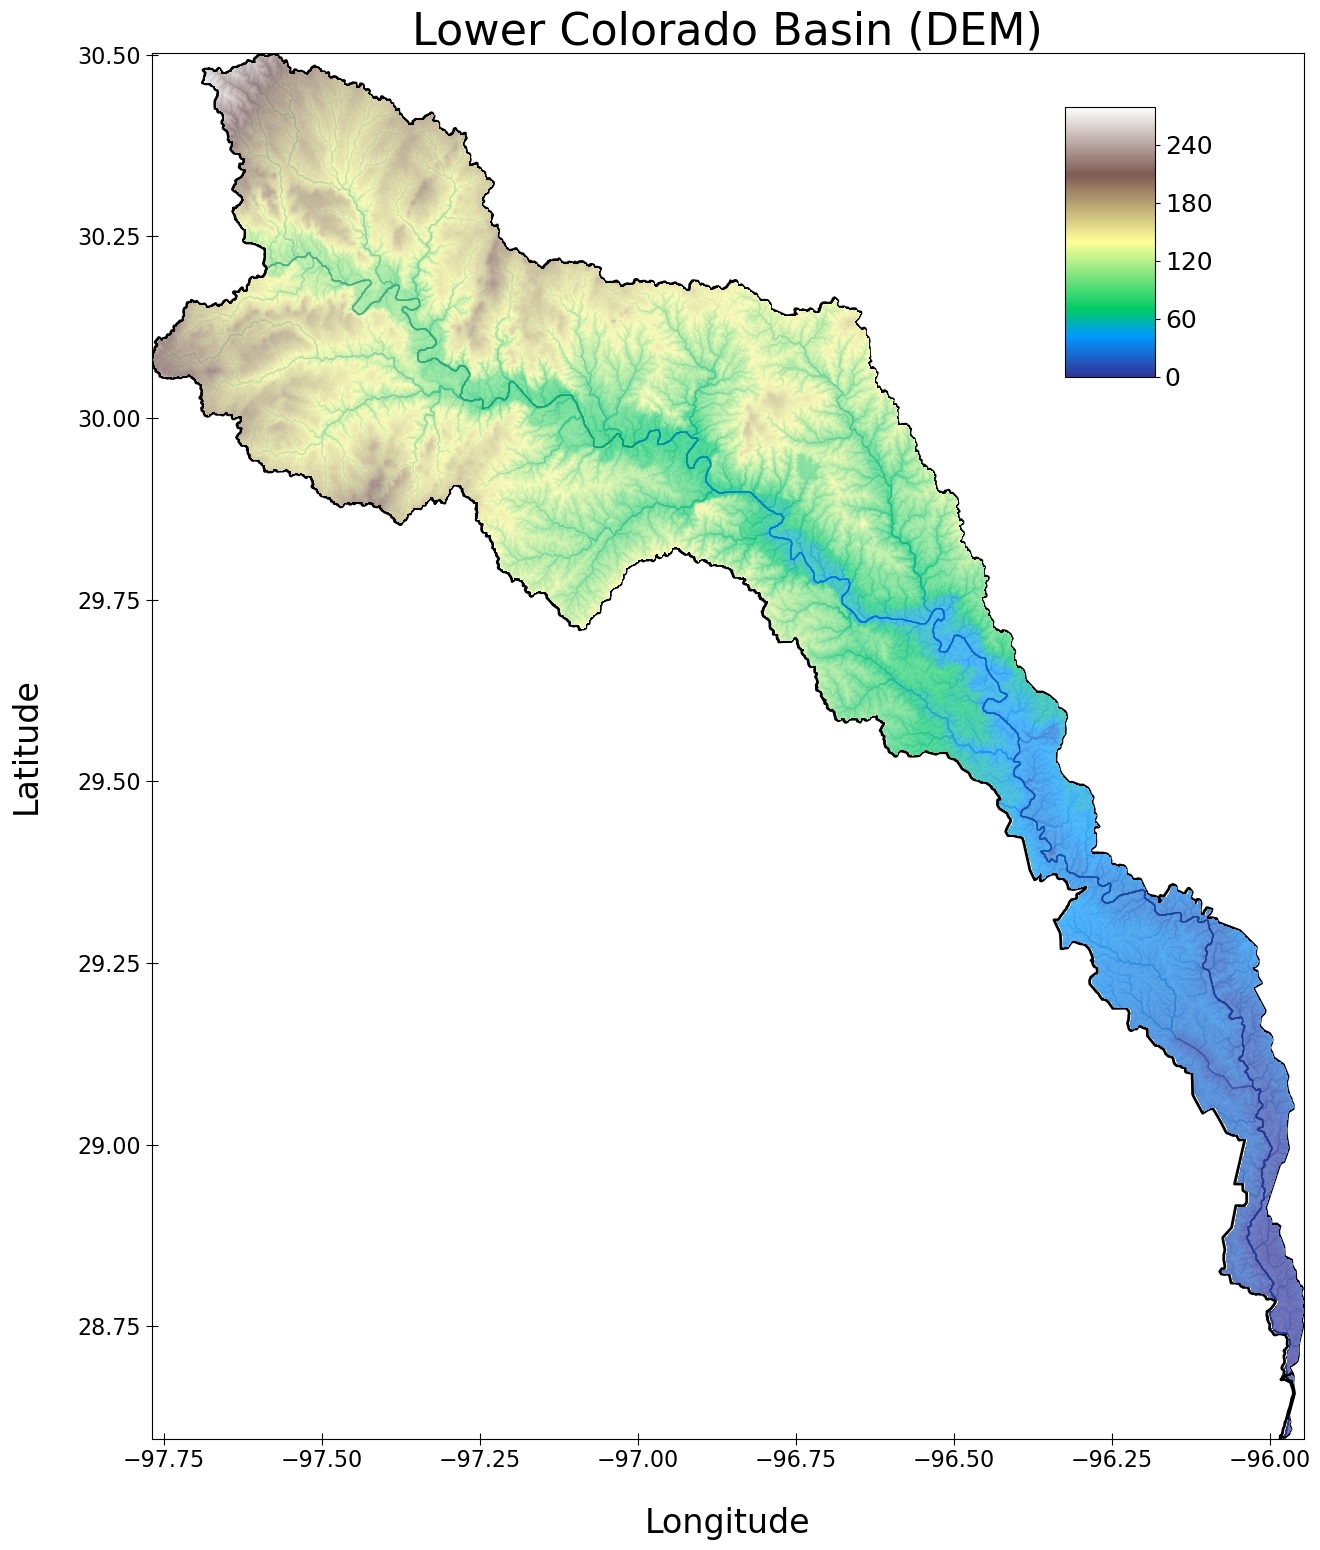

In [77]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 18))

# Open the first raster (e.g., DEM)
with rasterio.open("na_con_3s_Lower_Colorado.tif") as dem_raster:
    # Read the raster data
    dem_array = dem_raster.read(1)
    # Mask nodata values
    nodata = dem_raster.nodata
    dem_masked_array = np.ma.masked_where(dem_array == nodata, dem_array)
    # Display the raster
    dem_img = ax.imshow(dem_masked_array, cmap='terrain', 
                        extent=[dem_raster.bounds[0], dem_raster.bounds[2], 
                                dem_raster.bounds[1], dem_raster.bounds[3]], zorder=1)

# Open the second raster (e.g., Flow accumulation)
with rasterio.open("na_acc_3s_Lower_Colorado.tif") as acc_raster:
    # Read the raster data
    acc_array = acc_raster.read(1)
    # Mask nodata values
    nodata = acc_raster.nodata
    acc_masked_array = np.ma.masked_where(acc_array == nodata, acc_array)
    # Display the raster with logarithmic scaling
    acc_img = ax.imshow(acc_masked_array, cmap='Blues', norm=LogNorm(), alpha=0.333, 
                        extent=[acc_raster.bounds[0], acc_raster.bounds[2], 
                                acc_raster.bounds[1], acc_raster.bounds[3]], zorder=2)



Lower_Colorado.plot(ax=ax, color='none', edgecolor='black', lw=2)
# Manually define a position for the colorbar inside the plot
cax_position = [0.70, 0.70, 0.05, 0.15]  # [left, bottom, width, height]
cax = fig.add_axes(cax_position)
colorbar = fig.colorbar(dem_img, cax=cax, orientation='vertical', pad=0.01, aspect=5, shrink=0.333)
colorbar.ax.tick_params(labelsize=18)
# Set the locator for the ticks
colorbar.locator = MaxNLocator(nbins=5)  # 'nbins' determines the maximum number of ticks
colorbar.update_ticks()
#cax.set_label(r'[$\frac{tonnes}{hectare}$]', fontsize=18, labelpad=15)

    
# Set title and labels
ax.set_title('Lower Colorado Basin (DEM)', fontsize=32)
ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

plt.show()


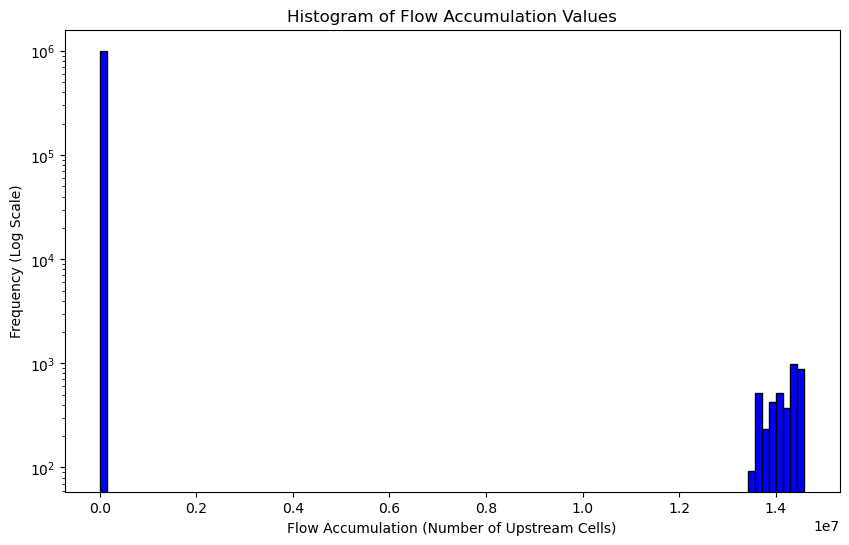

In [73]:
# Assuming flow_acc_values contains the non-masked flow accumulation values
plt.figure(figsize=(10, 6))
plt.hist(flow_acc_values, bins=100, log=True, color='blue', edgecolor='black')
plt.title('Histogram of Flow Accumulation Values')
plt.xlabel('Flow Accumulation (Number of Upstream Cells)')
plt.ylabel('Frequency (Log Scale)')
plt.show()
